# Import Statements

In [1]:
import sys
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import copy
from datetime import date, timedelta
import datetime
import yfinance as yf




sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline



def is_venv():
    return (hasattr(sys, 'real_prefix') or
            (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

if is_venv():
    print('inside virtualenv or venv')
else:
    print('outside virtualenv or venv')

outside virtualenv or venv


# Data Loading - Yahoo Finance

In [2]:
end = datetime.datetime.now()
start = datetime.datetime(end.year - 10, end.month, end.day)

In [8]:
df = yf.download('GOOGL', start, end)


[*********************100%%**********************]  1 of 1 completed


In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-16,26.626627,26.894144,26.576826,26.851351,26.851351,64015920
2013-12-17,26.847347,27.046045,26.736237,26.773273,26.773273,61366572
2013-12-18,26.823072,27.150902,26.502502,27.145897,27.145897,88323588
2013-12-19,27.046295,27.327078,27.004004,27.182684,27.182684,66561372
2013-12-20,27.234735,27.556807,27.227226,27.543043,27.543043,130333536


In [10]:
len(df)

2517

In [11]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Exploratory Data Analysis

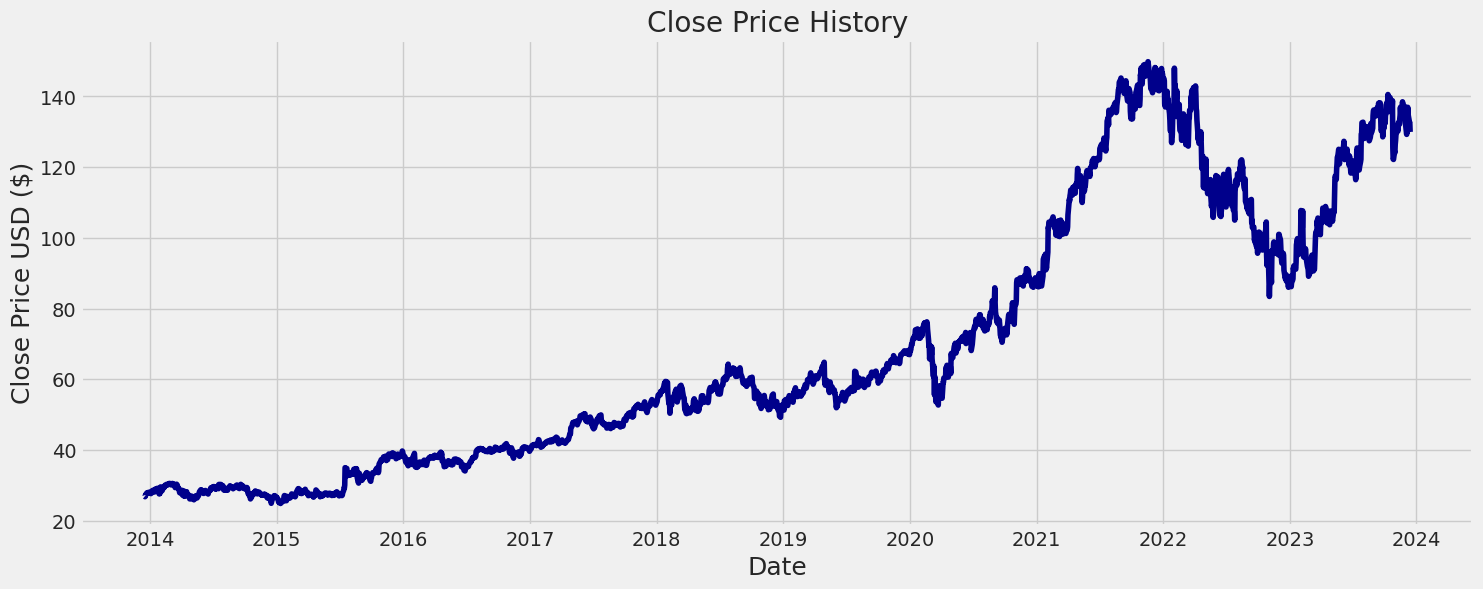

In [12]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'], color = 'darkblue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

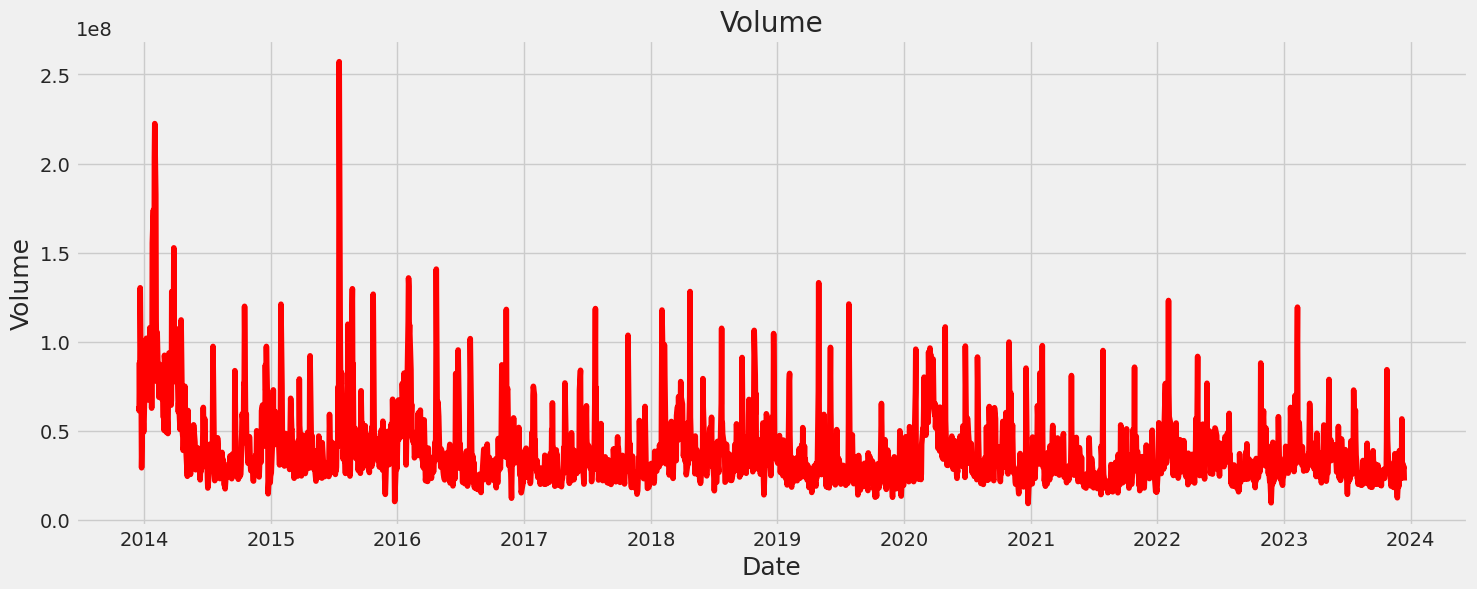

In [13]:
plt.figure(figsize=(16,6))
plt.title('Volume')
plt.plot(df['Volume'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.show()

# Data Preparation

In [14]:
data = df.filter(['Close'])


# Convert the dataframe to a numpy array
closing_prices = data.values


# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(closing_prices) * .95 ))

training_data_len


2392

## Data Standardization

In [15]:
# Min Max Scales Standardization




scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)


In [16]:
train_data = scaled_data[0:int(training_data_len), :]
train_data.shape

(2392, 1)

## Data Preparation - Train and Test
Sample Data Shape = (2332, 60, 1) - Considering 60 day window of data

In [17]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()



# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.01598866, 0.01536396, 0.0183453 , 0.01863963, 0.02152284,
       0.02442207, 0.02376934, 0.0248946 , 0.0250828 , 0.0232928 ,
       0.02554532, 0.02402563, 0.02239982, 0.02486656, 0.02917938,
       0.02965391, 0.02745346, 0.02744145, 0.02599984, 0.03128973,
       0.03113356, 0.03265526, 0.03151598, 0.03415293, 0.03441723,
       0.03343213, 0.02617003, 0.02164497, 0.02600584, 0.02278424,
       0.0284846 , 0.03761079, 0.02809217, 0.02903923, 0.03004835,
       0.0334041 , 0.036904  , 0.036001  , 0.03945485, 0.03875607,
       0.04140103, 0.04198166, 0.04359946, 0.04188956, 0.04224396,
       0.04217988, 0.04392584, 0.04542551, 0.04545954, 0.04526734,
       0.04455455, 0.04195964, 0.04440637, 0.04507711, 0.04534742,
       0.04438235, 0.04373763, 0.04141903, 0.04288268, 0.03923059])]
[0.03597495241681323]

[array([0.01598866, 0.01536396, 0.0183453 , 0.01863963, 0.02152284,
       0.02442207, 0.02376934, 0.0248946 , 0.0250828 , 0.0232928 ,
       0.02554532, 0.02402563, 0.02

(2332, 60, 1)

In [18]:
x_train.shape

(2332, 60, 1)

# Model Initialization and Training

In [19]:

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')




# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2332/2332 [==============================] - 145s 61ms/step - loss: 0.0016


## Model Testing

In [20]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test




x_test = []
y_test = closing_prices[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])





# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 [==============================] - 1s 37ms/step


4.8009571381074565

<ipython-input-21-9ee2bb9558b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


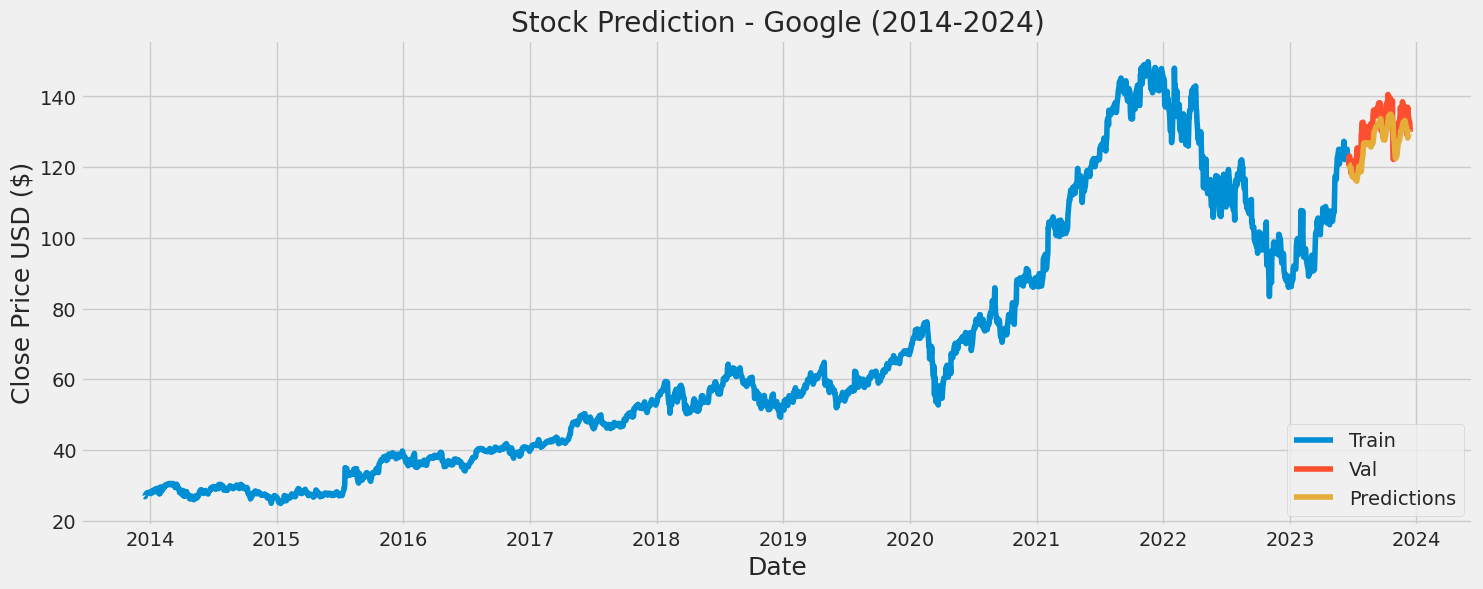

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions






# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2014-2024)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
valid

,Close,Predictions
Date,,
2023-06-20,123.099998,120.914597
2023-06-21,120.550003,120.840607
2023-06-22,123.150002,120.293556
2023-06-23,122.339996,120.090195
2023-06-26,118.339996,119.904167
...,...,...
2023-12-08,134.990005,128.827240
2023-12-11,133.289993,129.500641
2023-12-12,132.520004,129.845123


# **Prediction for Future**

In [23]:
# Model Prediction for next days -



def prediction_upcoming_days(dataframe, n_days = 20):
    previous_data_stream = list(data[len(data) - 60:].values)

    thirty_day_predictions = []


    for i in range(n_days):


      print("------------ ", str(i)," iteration -------------")

      prev_data_array = np.array(previous_data_stream)



      # Data Pre-Processing
      last_data_test = scaler.fit_transform(prev_data_array)
      last_data_test.shape


      testing = []
      testing.append(last_data_test)

      last_Data = np.array(testing)
      last_Data = np.reshape(last_Data, (last_Data.shape[0], last_Data.shape[1], 1))
      last_Data.shape



      # Predictions
      prediction_tomorrow = model.predict(last_Data)


      # Inverse Transform
      prediction_tomorrow = scaler.inverse_transform(prediction_tomorrow)
      prediction_tomorrow_value = float(prediction_tomorrow[0][0])
      prediction_tomorrow_value = np.array([prediction_tomorrow_value])

      # Value Storage
      thirty_day_predictions.append(prediction_tomorrow_value)


      previous_data_stream
      # Appending previous data stream
      previous_data_stream = previous_data_stream[1:]
      previous_data_stream.append(prediction_tomorrow_value)

    return thirty_day_predictions

  # import pdb; pdb.set_trace();

In [24]:



df_future_preds = pd.DataFrame()




thirty_day_predictions = prediction_upcoming_days(data, n_days = 20)


today = date.today()
dates = []
price_val = []
for i in range(len(thirty_day_predictions)):
  td = timedelta(days=i)
  my_date = today + td
  dates.append(my_date)
  price_val.append(thirty_day_predictions[i][0])

df_future_preds['Date'] = dates
df_future_preds['Close'] = price_val
df_future_preds.set_index('Date', inplace=True)
df_future_preds.head()

------------  0  iteration -------------
1/1 [==============================] - 0s 55ms/step
------------  1  iteration -------------
1/1 [==============================] - 0s 59ms/step
------------  2  iteration -------------
1/1 [==============================] - 0s 56ms/step
------------  3  iteration -------------
1/1 [==============================] - 0s 66ms/step
------------  4  iteration -------------
1/1 [==============================] - 0s 61ms/step
------------  5  iteration -------------
1/1 [==============================] - 0s 207ms/step
------------  6  iteration -------------
1/1 [==============================] - 0s 155ms/step
------------  7  iteration -------------
1/1 [==============================] - 0s 163ms/step
------------  8  iteration -------------
1/1 [==============================] - 0s 208ms/step
------------  9  iteration -------------
1/1 [==============================] - 0s 140ms/step
------------  10  iteration -------------
1/1 [==================

,Close
Date,
2023-12-14,132.380066
2023-12-15,132.122345
2023-12-16,131.970627
2023-12-17,131.869980
2023-12-18,131.793579


In [25]:
train_latest = train['Close'][2300:]

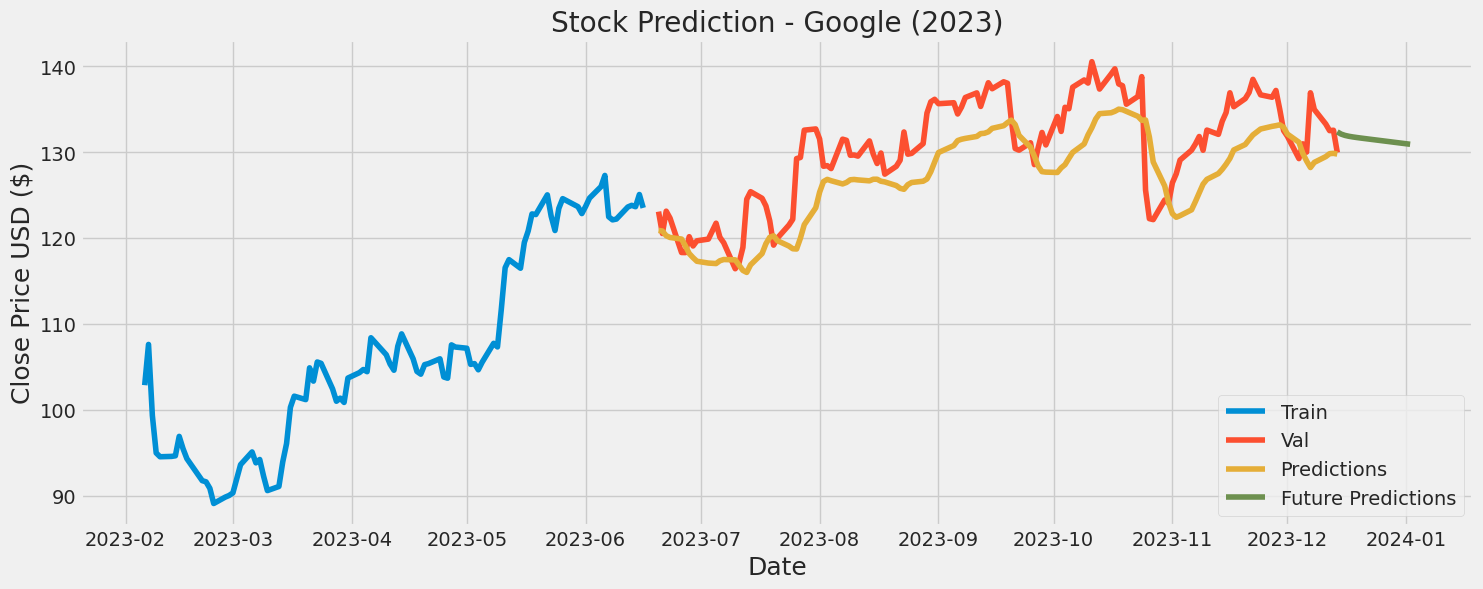

In [26]:
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2023)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][2300:])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(df_future_preds['Close'])
plt.legend(['Train', 'Val', 'Predictions','Future Predictions'], loc='lower right')
plt.show()

In [27]:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2023-06-20,123.099998,120.914597
2023-06-21,120.550003,120.840607
2023-06-22,123.150002,120.293556
2023-06-23,122.339996,120.090195
2023-06-26,118.339996,119.904167
...,...,...
2023-12-08,134.990005,128.827240
2023-12-11,133.289993,129.500641
2023-12-12,132.520004,129.845123


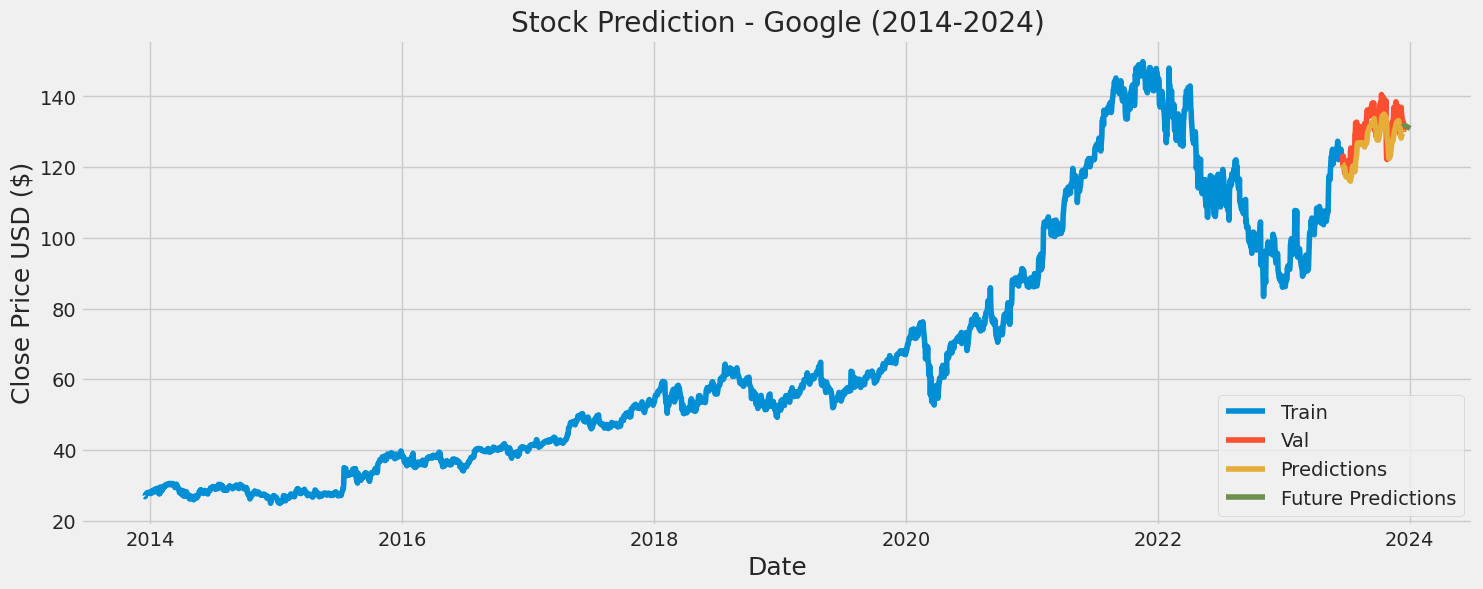

In [28]:

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2014-2024)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(df_future_preds['Close'])
plt.legend(['Train', 'Val', 'Predictions','Future Predictions'], loc='lower right')
plt.show()

In [29]:
df2 = yf.download('CMG', start, end)

[*********************100%%**********************]  1 of 1 completed


In [30]:
len(df2)

2517

[array([0.12642016, 0.12510833, 0.12714312, 0.12603715, 0.13492319,
       0.13391298, 0.13490881, 0.13601957, 0.13377891, 0.13439652,
       0.13475084, 0.13027429, 0.13404702, 0.13213672, 0.13488488,
       0.13622064, 0.13870072, 0.13752292, 0.13332407, 0.1335539 ,
       0.13449707, 0.13318524, 0.13227556, 0.13129887, 0.12669307,
       0.1207084 , 0.11545625, 0.11393853, 0.11516419, 0.11163563,
       0.11616483, 0.14393371, 0.13973965, 0.13849006, 0.13937098,
       0.14034767, 0.14265536, 0.14208086, 0.1405344 , 0.14095572,
       0.14665793, 0.14496305, 0.14436459, 0.14403903, 0.14312937,
       0.14275112, 0.14509233, 0.14520723, 0.14544662, 0.14832885,
       0.15027746, 0.14519765, 0.15967099, 0.15795698, 0.16371184,
       0.16377885, 0.16116956, 0.15940288, 0.16152385, 0.15711912])]
[0.15542427498177874]

[array([0.12642016, 0.12510833, 0.12714312, 0.12603715, 0.13492319,
       0.13391298, 0.13490881, 0.13601957, 0.13377891, 0.13439652,
       0.13475084, 0.13027429, 0.13

<ipython-input-33-f85384bc52ab>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


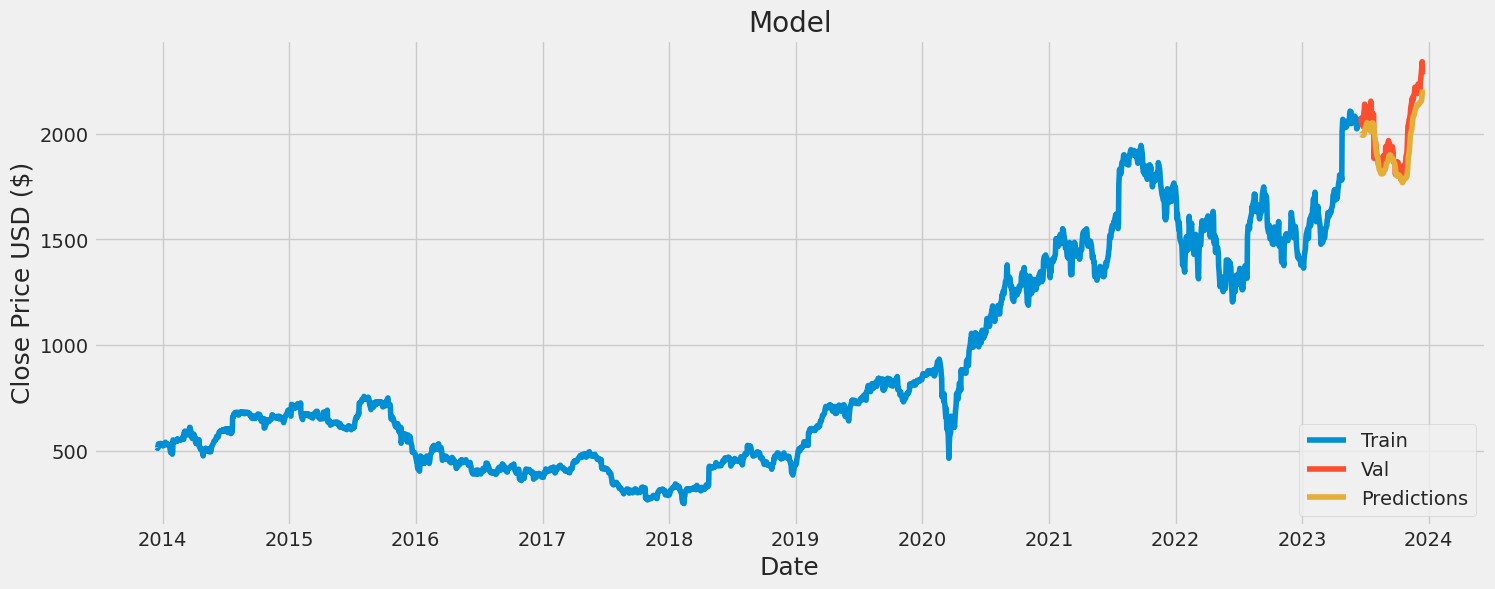

In [33]:




data = df2.filter(['Close'])
# print(data)


# Convert the dataframe to a numpy array
closing_prices = data.values


# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(closing_prices) * .95 ))

training_data_len


# Scale the data
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# scaled_data

train_data = scaled_data[0:int(training_data_len), :]
train_data.shape


x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()



# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = closing_prices[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))




# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("THE RMSE USING GOOGLE MODEL IS ---- ", )





train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()





In [32]:
# valid

In [6]:
def stock_prediction(data_frame, stock):




      data = data_frame.filter(['Close'])
      # print(data)


      # Convert the dataframe to a numpy array
      closing_prices = data.values


      # Get the number of rows to train the model on
      training_data_len = int(np.ceil( len(closing_prices) * .95 ))





      scaler = MinMaxScaler(feature_range=(0,1))
      scaled_data = scaler.fit_transform(closing_prices)

      # scaled_data

      train_data = scaled_data[0:int(training_data_len), :]
      train_data.shape


      x_train = []
      y_train = []

      for i in range(60, len(train_data)):
          x_train.append(train_data[i-60:i, 0])
          y_train.append(train_data[i, 0])
          # if i<= 61:
          #     print(x_train)
          #     print(y_train)
          #     print()



      # Convert the x_train and y_train to numpy arrays
      x_train, y_train = np.array(x_train), np.array(y_train)

      # Reshape the data
      x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
      x_train.shape


      # MODEL BUILDING
      model_stock = Sequential()
      model_stock.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
      model_stock.add(LSTM(64, return_sequences=False))
      model_stock.add(Dense(25))
      model_stock.add(Dense(1))

      # Compile the model
      model_stock.compile(optimizer='adam', loss='mean_squared_error')




      # Train the model
      model_stock.fit(x_train, y_train, batch_size=1, epochs=2)










      test_data = scaled_data[training_data_len - 60: , :]
      # Create the data sets x_test and y_test
      x_test = []
      y_test = closing_prices[training_data_len:, :]
      for i in range(60, len(test_data)):
          x_test.append(test_data[i-60:i, 0])

      # Convert the data to a numpy array
      x_test = np.array(x_test)

      # Reshape the data
      x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))




      # Get the models predicted price values
      predictions = model_stock.predict(x_test)
      predictions = scaler.inverse_transform(predictions)

      # Get the root mean squared error (RMSE)
      rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
      print("THE RMSE USING {} MODEL IS ---- {}".format(stock,rmse))





      train = data[:training_data_len]
      valid = data[training_data_len:]
      valid['Predictions'] = predictions
      # Visualize the data
      plt.figure(figsize=(16,6))
      plt.title('Model')
      plt.xlabel('Date', fontsize=18)
      plt.ylabel('Close Price USD ($)', fontsize=18)
      plt.plot(train['Close'])
      plt.plot(valid[['Close', 'Predictions']])
      plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
      plt.show()


      return predictions


[*********************100%%**********************]  1 of 1 completed
Epoch 1/2
441/441 [==============================] - 31s 62ms/step - loss: 8.5499e-04
Epoch 2/2
1/1 [==============================] - 1s 1s/step
THE RMSE USING Rivian MODEL IS ---- 3.828858925264214


<ipython-input-6-df3a220c443c>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


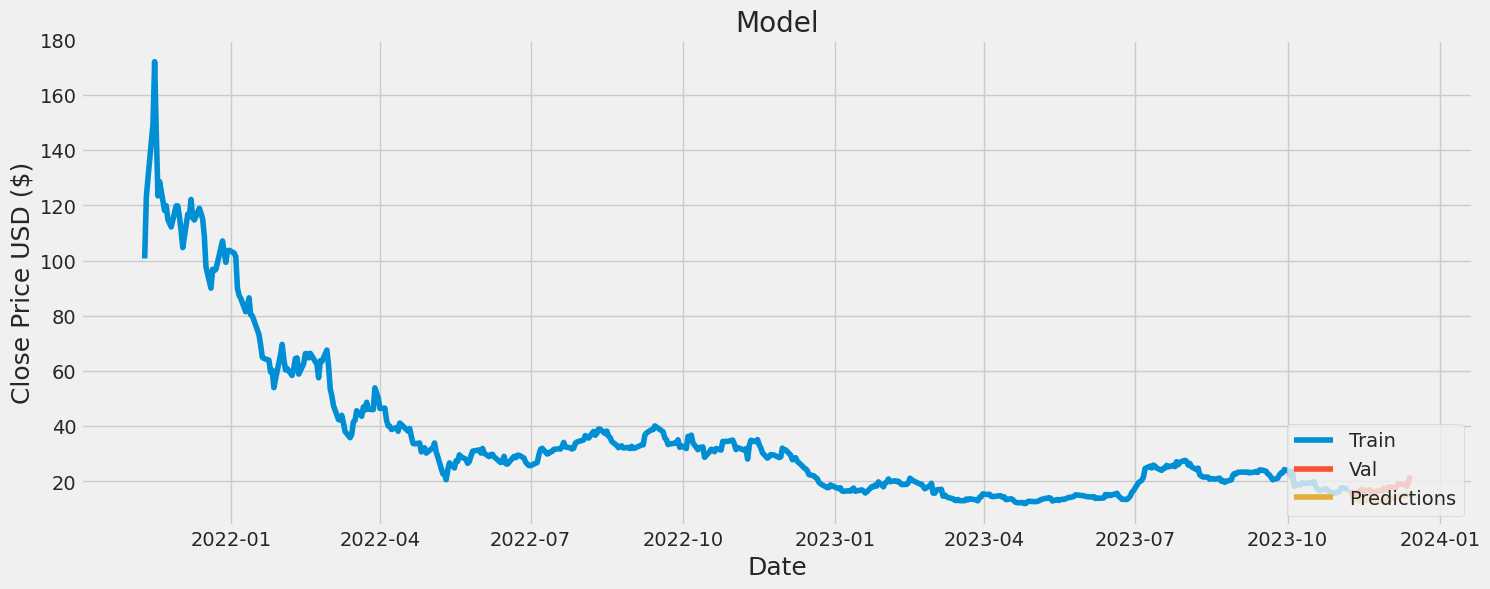

In [7]:

df_stock = yf.download('RIVN', start, end)

predictions = stock_prediction(df_stock, "Rivian")